In [12]:
## IMPORTS
import numpy as np
from numpy.polynomial.legendre import leggauss
import scipy
from scipy.io import loadmat
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import math
import pyshtools as pysh
import pandas as pd
import os

In [13]:
## PARAMETERS
rhoi=917    
rhow=1000   
a=6378100  
Me=5.972e24 

N = 256

In [14]:
# Gauss Legendre Grid Set-up
def Legendre(n,x):
    x=np.asarray(x)
    c = np.zeros(n+1)
    c[-1]=1
    return np.polynomial.legendre.legval(x,c)


def DLegendre(n,x):
    x=np.asarray(x)
    if (n==0):
        return x*0
    elif (n==1):
        return x*0+1.0
    else:
        return (n/(x**2-1.0))*(x*Legendre(n,x)-Legendre(n-1,x))

def GaussLegendreWeights(N,x):
    W=[]
    xis=x
    W=2.0/( (1.0-xis**2)*(DLegendre(N,xis)**2) )
    return W
    
x = scipy.special.roots_legendre(N)[0]
w = GaussLegendreWeights(N,x);

x_GL = np.arccos(x)*180/np.pi - 90; 
lon_GL = np.linspace(0,360,2*N+1);
lon_GL = lon_GL[0:-1];
lon_out,lat_out = np.meshgrid(lon_GL,x_GL);

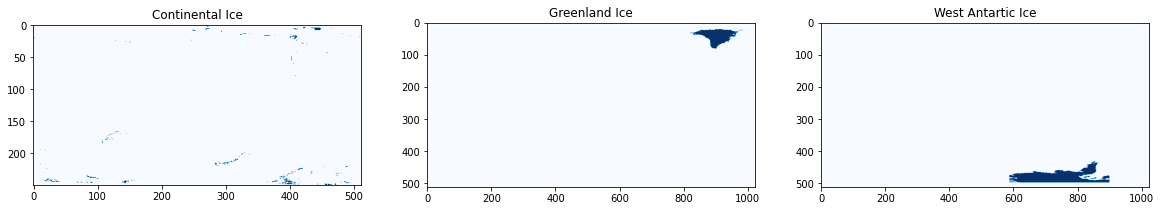

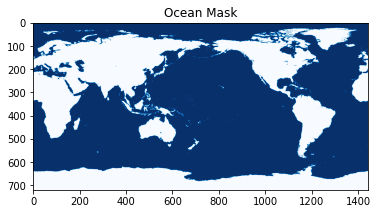

In [53]:
## MASKS

# Mat1: Greenland and Wais
mat = loadmat("data/ice_masks.mat")
lon_mask = np.array(mat["lon_mask"])
lat_mask = np.array(mat["lat_mask"])
Greenland_mask = np.where(np.array(mat['Greenland_mask'])>0,1,0)
WAIS_mask = np.where(np.array(mat['WAIS_mask'])>0,1,0)

# Mat2: Continental 
mat_cont = loadmat("data/cont_mask.mat")
Cont_mask = np.where(np.array(mat_cont["continental_glaciers_mask"])>0,1,0)

# Mat3: Ocean (Topographic)
mat = loadmat("data/topography.mat")
lat_topo = np.array(mat["lat_topo"])
lon_topo = np.array(mat["lon_topo"])
topo_ice = np.array(mat["topo_ice"])
x = interp2d(lon_topo, lat_topo, topo_ice)
topo_pres = x(lon_out[0,:], lat_out[:,0])
C = np.where(topo_ice > 0, 0, 1)

# Visualization
fig, ax = plt.subplots(1,3,figsize=(20, 100))
cm = 'Blues'
ax[0].imshow(Cont_mask,cmap=cm)
ax[0].set_title('Continental Ice')
ax[1].imshow(Greenland_mask,cmap=cm)
ax[1].set_title('Greenland Ice')
ax[2].imshow(WAIS_mask,cmap=cm)
ax[2].set_title('West Antartic Ice')
plt.savefig('Mask Visual.png')
plt.show()

plt.imshow(np.flip(np.flip(C), axis=1),cmap = 'Blues')
plt.title('Ocean Mask')
plt.savefig('Ocean Mask Visual')
plt.show()

In [52]:
os.chdir('data/')

In [46]:
def fingerprint(ice_sheet,topo_ice,lon_out,lat_out,maxdeg,w,rhoi,rhow,a,Me,N):

    # Set constants needed for pysh to perform the spherical harmonic 
    # transform 
    lmax=N #used to be 361
    lreturn=N

    # Set-up grid and variables pysh uses for the spherical harmonic transform
    zero, w = pysh.expand.SHGLQ(lmax)                 # Transform variables
    latglq, longlq = pysh.expand.GLQGridCoord(lmax)   # Transform grid

    # Interpolate topo_ice from the input lon_out/lat_out grid onto the 
    # longlq/latglq grid
    # todo: interpolate onto old grid
    # todo: project onto new grid, save as topo_pres
    
    y = interp2d(lon_out, lat_out, topo_ice)
    topo_pres = y(longlq, latglq)
    
    C = topo_pres; 
    # todo:  set all land to 0
    C[C>0]=0
    # todo: set all ocean to 1
    C[C<0]=1
    
    # Do spherical harmonic transform of C into C_lm
    # we do this because we need the mask in spherical coordinates to calculate
    # the fingerprint
    c_lm = pysh.expand.SHExpandGLQC(C,w,zero,norm=1,csphase=1,lmax_calc=lreturn)


    # Load in ice masks
    if str(ice_sheet)=='continental_glaciers_mask':
        mat = loadmat("cont_mask.mat")
        lon_mask = np.array(mat["lon_mask"])
        lon_mask = lon_mask[0,:]
        lat_mask = np.array(mat["lat_mask"])
        lat_mask = lat_mask[:,0]
        ice_mask=np.array(mat["continental_glaciers_mask"])
    else:
        mat = loadmat("ice_masks.mat")
        lon_mask = np.array(mat["lon_mask"])
        lat_mask = np.array(mat["lat_mask"])
        ice_mask=np.array(mat[str(ice_sheet)]) 

    # Interpolate the mask on the the GL grid
    x=interp2d(lon_mask,lat_mask,ice_mask)
    ice_mask_interp = x(longlq, latglq)

    # Make sure the mask is all zeros and ones because the interpolation can
    # alter the values
    ice_mask_interp[ice_mask_interp<0]=0
    ice_mask_interp[ice_mask_interp>0]=1

    # Do spherical harmonic transform of Greenland mask
    #todo
    ice_mask_lm = pysh.expand.SHExpandGLQC(ice_mask_interp,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

    # Re-calculate C for use later in the code (we did this for you)
    topoglq2 = y(longlq,latglq)
    cilm_topo = pysh.expand.SHExpandGLQC(topoglq2,w,zero,norm=1,csphase=1,lmax_calc=lreturn)
    zero_down, w_down = pysh.expand.SHGLQ(lreturn)
    topo_down_grid = pysh.expand.MakeGridGLQC(cilm_topo,zero_down,lmax=lreturn,norm=1,csphase=1,lmax_calc=lreturn)
    topo_down = np.sign(topo_down_grid).real*np.abs(topo_down_grid)
    C=np.copy(topo_down)
    C[C>0]=0
    C[C<0]=1

    ## Start by making a a first guess about sea-level change
    # we don't know how sea-level changes with our ice melt scenario. Let's
    # make a simple first guess. Sea level grows uniformly (i.e., there is no
    # spatially-varying component) by 1cm due to ice melt.
    #delta_S_guess = .01; # in meters
    #eustatic = .01       # additionally save it as eustatic for later use in the code

    if str(ice_sheet)=='Greenland_mask':
        delta_S_guess = .08
    else:
        delta_S_guess = .11
    ## Use first guess to calculate delta_I, mask of the (uniform) ice height change

    # calculate the area of the ocean and area of ice first
    # the 1st value of a spherical harmonic xxx is the area because??
    area_ocean = c_lm[0][0,0].real
    area_ice = ice_mask_lm[0][0,0].real

    # Calculate ice height change
    # .01 m ocean water * rhow * ocean area = mass of water (kg)
    # mass of water / rhoi = ice volume (m^3)
    # [volume = area * height]
    # ice volume / area of GrIS ice = height of ice (m)
    height_ic = (delta_S_guess*rhow* area_ocean)/(rhoi*area_ice)  # todo

    # Calculate delta_I (project onto GrIS mask)
    delta_I = -height_ic * ice_mask_interp # todo

    # Spherical harmonic transform
    delta_I_lm = pysh.expand.SHExpandGLQC(delta_I,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

    ## Import the Elastic Love numbers
    # Love numbers are dimensionless numbers that represent the way a plantery 
    # body responds to changes in mass loads on its surface
    lovenumbers=np.loadtxt('lovenumbers_python.txt')
    
    M_e=5.972*10**24   
    love_h=lovenumbers[:,1]
    love_k=lovenumbers[:,2]
    l=np.zeros([2,N+1,N+1])
    k_l=np.zeros([2,N+1,N+1])
    h_l=np.zeros([2,N+1,N+1])
    #l=np.zeros([2,65,65])
    #k_l=np.zeros([2,65,65])
    #h_l=np.zeros([2,65,65])
    i,j,k=l.shape
    for ii in np.arange(0,i):
        for jj in np.arange(0,j):
            for kk in np.arange(0,k):
                l[ii,jj,kk]=jj
    for ii in np.arange(0,i):
        for jj in np.arange(0,j):
            for kk in np.arange(0,k):
                k_l[ii,jj,kk]=love_k[jj]
    for ii in np.arange(0,i):
        for jj in np.arange(0,j):
            for kk in np.arange(0,k):
                h_l[ii,jj,kk]=love_h[jj]

    # Calculate Tl and El for use later in the code
    E_l=1+k_l-h_l
    T_l=(4*np.pi*a**3)/(M_e*(2*l+1))


    ## Calculate the initial delta_S, the first guess eustatic ocean height change.
    delta_S = -rhoi/rhow * delta_I_lm[0][0,0]/c_lm[0][0,0]*C#todo

    # spherical harmonic transform - why do we first have to do a transform of this?
    delta_S_lm = pysh.expand.SHExpandGLQC(delta_S,w,zero,norm=1,csphase=1,lmax_calc=lreturn) # todo

    ## Create a loop to iteratively calculate delta_SL, global sea-level variation

    #convergence criterion
    epsilon = 1e-4;
    # set a maximum iteration - don't want the loop to go forever & crash
    maxiter = 10;

    for i in np.arange(1,maxiter):
        #calculate delta SL
        temp =  rhoi* delta_I_lm+rhow*delta_S_lm # todo
        
        #convert from spherical back to spatial coordinates
        delta_SL = pysh.expand.MakeGridGLQC((temp*T_l*E_l),zero_down,lmax=lreturn,norm=1,csphase=1,lmax_calc=lreturn) #TlEl is the wrong size - I'll come back to that later, old code: TlEl*temp
        
        #calculate RO (project onto ocean mask)
        delta_RO = delta_SL*C # todo
        #convert to spherical harmonic coordinates
        delta_RO_lm = pysh.expand.SHExpandGLQC(delta_RO,w,zero,norm=1,csphase=1,lmax_calc=lreturn)

        #calculate delta phi / g (eustatic sea-level change)
        delta_phi_g = - rhoi/rhow* delta_I_lm[0][0,0]/c_lm[0][0,0] - delta_RO_lm[0][0,0]/c_lm[0][0,0]
        #calculate new delta S
        delta_S_new = (delta_SL+delta_phi_g)*C # todo
        #delta_S_down = np.sign(delta_S_new).real*np.abs(delta_S_new)
        #convert to spherical harmonics to plug back in to first equation
        delta_S_lm_new =pysh.expand.SHExpandGLQC(delta_S_new,w,zero,norm=1,csphase=1,lmax_calc=lreturn) # todo

        #check convergence
        chi = np.max(np.abs(delta_S_new - delta_S))
        if chi < epsilon:
            print('Converged after ', str(i), ' iterations. Chi was ', str(np.real(chi)))
            print("")
            break

        delta_S = np.copy(delta_S_new) 
        delta_S_lm = np.copy(delta_S_lm_new)

    # Normalize your results against the eustatic

    # Calculate the final ocean height change from the loop (hint: the final
    # delta S not projected onto the ocean mask)
    sea_level = delta_SL+delta_phi_g # todo - don't want to project onto the ocean as before

    # Normalize sea level against the eustatic
    #fingerprint = sea_level #/0.01# todo

    return sea_level.real

In [48]:
GrIS_fingerprint = fingerprint("Greenland_mask", topo_ice,lon_topo, lat_topo, N, w, rhoi, rhow, a, Me,N)
WAIS_fingerprint = fingerprint("WAIS_mask", topo_ice,lon_topo, lat_topo, N, w, rhoi, rhow, a, Me,N)
Cont_fingerprint = fingerprint("continental_glaciers_mask", topo_ice,lon_topo, lat_topo, N, w, rhoi, rhow, a, Me,N)

Converged after  6  iterations. Chi was  3.7635173384786835e-05

Converged after  6  iterations. Chi was  4.84704001043057e-05

Converged after  5  iterations. Chi was  8.701719282307174e-05



In [ ]:
os.chdir('..')

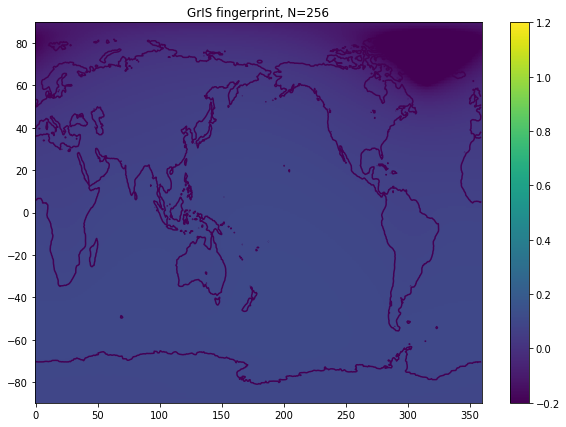

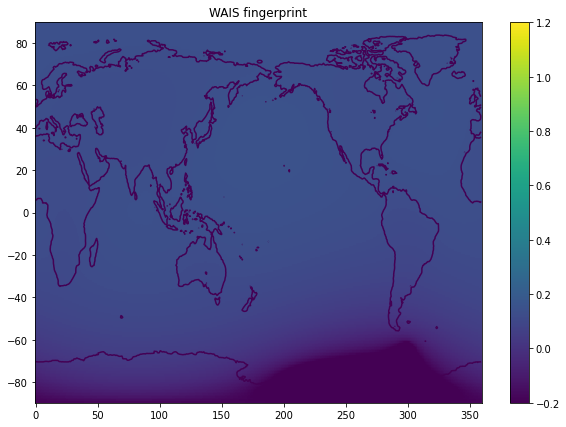

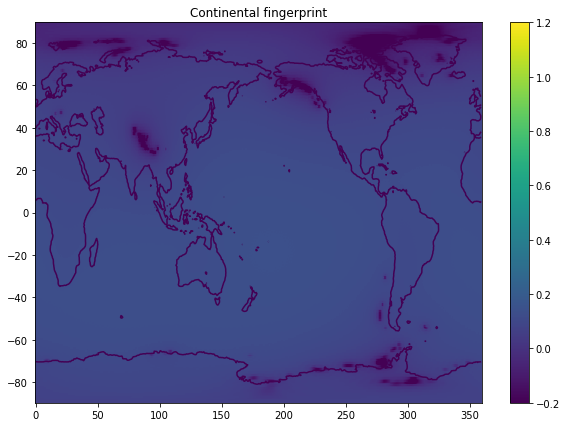

In [54]:
## Plot the Fingerprints
# GrIS
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(GrIS_fingerprint.real[0:N,0:2*N])), vmin=-0.2, vmax=1.2) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres)),levels=[0])
plt.title('GrIS fingerprint, N=256')
plt.savefig('GrIS_fingerprint.png')
plt.show()
# WAIS
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(WAIS_fingerprint.real[0:N,0:2*N])), vmin=-0.2, vmax=1.2) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres)),levels=[0])
plt.plot()
plt.title('WAIS fingerprint')
plt.savefig('WAIS_fingerprint.png')
plt.show()
# Cont
fig = plt.figure(figsize=(10,7))
plt.pcolor(lon_out, lat_out, np.fliplr(np.flip(Cont_fingerprint.real[0:N,0:2*N])), vmin=-0.2, vmax=1.2) #x,y,c 
plt.colorbar()
plt.contour(lon_out, lat_out,np.fliplr(np.flip(topo_pres)),levels=[0])
plt.plot()
plt.title('Continental fingerprint')
plt.savefig('Cont_fingerprint.png')
plt.show()